In [1]:
import keras
from keras import layers
from keras import ops
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

2024-09-01 17:50:18.667934: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train/255

5

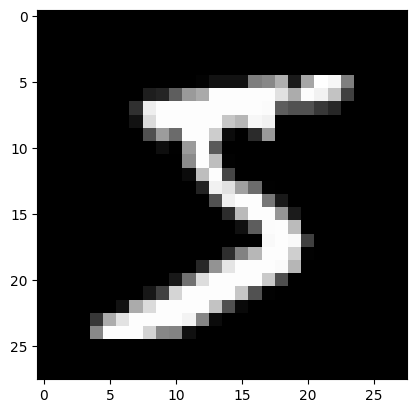

In [3]:
plt.imshow(x_train[0], cmap="gray")
y_train[0]

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 209,968 (820.19 KB)

 Trainable params: 209,968 (820.19 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:

class AE(keras.Model):
    def __init__(self, latent_dim=2):
        super().__init__()
        self.h1 = layers.Dense(128, activation="relu")
        self.h2 = layers.Dense(latent_dim)
        self.h3 = layers.Dense(128, activation="relu")
        self.h4 = layers.Dense(784, activation="sigmoid")

    def call(self, x):
        x = self.h1(x)
        latent = self.h2(x)
        x = self.h3(latent)
        x = self.h4(x)
        return x, latent

class AETrainer(keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.flatten = layers.Flatten(input_shape=(28, 28, 1))
        self.reconstruction_loss_tracker = keras.metrics.Mean(
                name="reconstruction_loss"
            )
    
    @property
    def metrics(self):
        return [self.reconstruction_loss_tracker]
    
    def train_step(self, data):
        # forward
        with tf.GradientTape() as tape:
            x = self.flatten(data)
            x_hat, _ = self.model(x)
            loss = ops.mean(keras.losses.mean_squared_error(x, x_hat))
            
        # learn
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
        
        # update metrics to show during training
        self.reconstruction_loss_tracker.update_state(loss)
        return {
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
        }


ae = AE(latent_dim=2)
t = AETrainer(ae)
t.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))
t.fit(x_train, epochs=15, batch_size=128)

Epoch 1/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - reconstruction_loss: 0.0865
Epoch 2/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - reconstruction_loss: 0.0538
Epoch 3/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - reconstruction_loss: 0.0501
Epoch 4/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - reconstruction_loss: 0.0483
Epoch 5/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - reconstruction_loss: 0.0472
Epoch 6/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - reconstruction_loss: 0.0465
Epoch 7/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - reconstruction_loss: 0.0458
Epoch 8/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - reconstruction_loss: 0.0454
Epoch 9/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - reconstruction_loss: 0.0449
Epoch 10/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - reconstruction_loss: 0.0445
Epoch 11/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - reconstruction_loss: 0.0440
Epoch 12/15
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - reconstruction_loss: 0.0439
Epoch 13/15
4

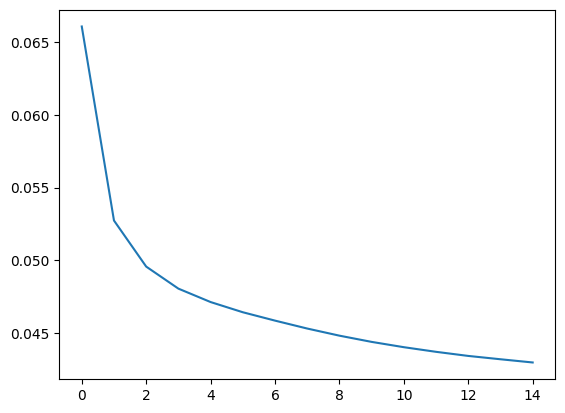

In [41]:
plt.plot(t.history.history["reconstruction_loss"])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


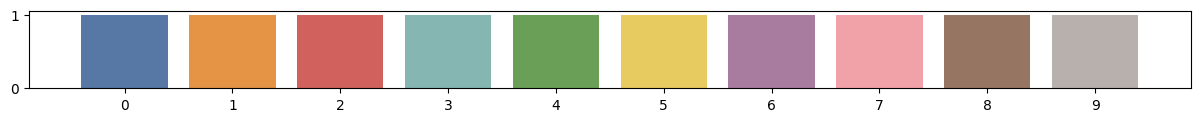

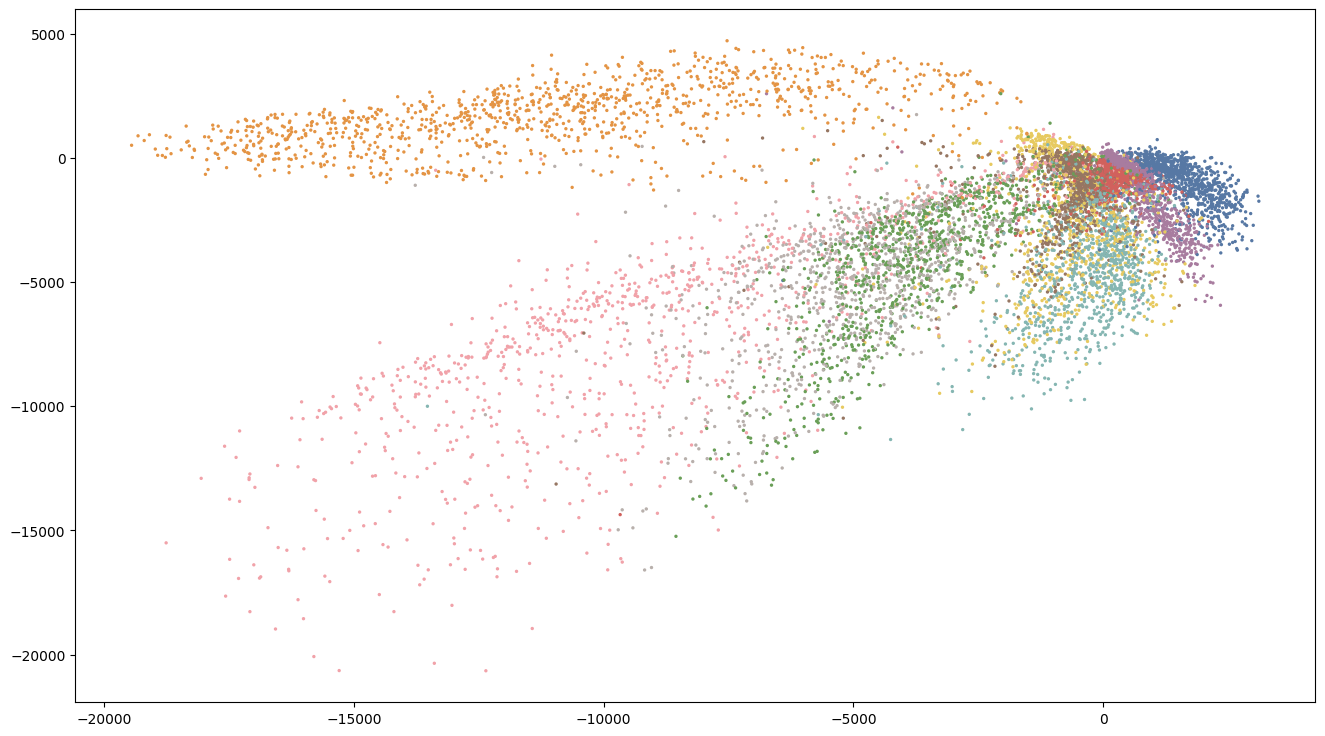

In [47]:
# now visualize the embedding space
def compute_embeddings(model, x_train, y_train):
	_, latents = model.predict(x_train.reshape(-1, 784))
	return latents, y_train

def custom_legend(colors, labels):
	fig, ax = plt.subplots()
	fig.set_figwidth(15)
	fig.set_figheight(1)
	ax.bar(labels, [1 for i in range(len(labels))], label=labels, color=colors)
	return ax

def plot_mnist(latents, labels):
	tab10 = ["#5778a4", "#e49444", "#d1615d", "#85b6b2", "#6a9f58", "#e7ca60", "#a87c9f", "#f1a2a9", "#967662", "#b8b0ac"]
	custom_legend(tab10, [str(i) for i in range(10)])
	plt.show()
	plt.figure(figsize=(16, 9))
	plt.scatter(latents[:, 0], latents[:, 1], c=[tab10[i] for i in labels.tolist()], s=2, alpha=1)

latents, labels = compute_embeddings(ae, x_test, y_test)
plot_mnist(latents, labels)